In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
import time

In [2]:
pathToData = '.\\emnist\\'
img_rows = img_cols = 28

def loadBinData(pathToData, img_rows, img_cols): 
    print('Загрузка данных из двоичных файлов...') 
    with open(pathToData + 'imagesTrain.bin', 'rb') as read_binary: 
        x_train = np.fromfile(read_binary, dtype = np.uint8) 
    with open(pathToData + 'labelsTrain.bin', 'rb') as read_binary: 
        y_train = np.fromfile(read_binary, dtype = np.uint8) 
    with open(pathToData + 'imagesTest.bin', 'rb') as read_binary: 
        x_test = np.fromfile(read_binary, dtype = np.uint8) 
    with open(pathToData + 'labelsTest.bin', 'rb') as read_binary: 
        y_test = np.fromfile(read_binary, dtype = np.uint8) 

    x_train = np.array(x_train[16:], dtype = 'float32') / 255 
    x_test = np.array(x_test[16:], dtype = 'float32') / 255
    if flatten or reshape:
        x_train = x_train.reshape(-1, img_rows, img_cols)
        x_test = x_test.reshape(-1, img_rows, img_cols) 
    y_train = y_train[8:]
    y_test = y_test[8:] 
    return x_train, y_train, x_test, y_test 

def history_plot(history):
    fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(10, 5))

    axs[0].plot(history.history['loss'], label='loss')
    axs[0].plot(history.history['val_loss'], label='val_loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend()
    axs[1].plot(history.history['accuracy'], label='accuracy')
    axs[1].plot(history.history['val_accuracy'], label='val_accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend()
    plt.show()


# MNIST

In [3]:
num_classes = 10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

print(x_train.shape)
print(x_test.shape)


(60000, 28, 28)
(10000, 28, 28)


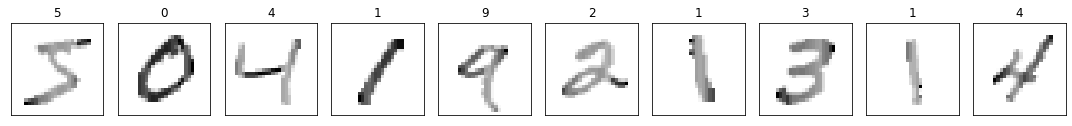

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axs.flat):
	ax.imshow(x_train[i], cmap=plt.cm.binary)
	ax.set_title(chr(y_train[i] + 48))
plt.tight_layout()
plt.show()

In [5]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten())
#model.add(tf.keras.layers.Reshape((784,)))
model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.35))
model.add(tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax))

model.compile(	optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), 
				loss='categorical_crossentropy', 
				metrics=['accuracy']
				)

start = time.time() 
history = model.fit(x_train, y_train_cat, validation_split=0.2, epochs=20, batch_size=2048)
display.clear_output()
print('Время вычислений:', time.time() - start)
tf.keras.backend.clear_session()

Время вычислений: 6.023252248764038


In [6]:
val_loss, val_acc = model.evaluate(x_test, y_test_cat)
print('Val(test set) accuracy: ', val_acc)
print('Accuracy: ', history.history['accuracy'][-1])
print('Val accuracy: ', history.history['val_accuracy'][-1])

313/313 [==============================] - 1s 3ms/step - loss: 0.1699 - accuracy: 0.9619
Val(test set) accuracy:  0.961899995803833
Accuracy:  0.9680625200271606
Val accuracy:  0.9611666798591614


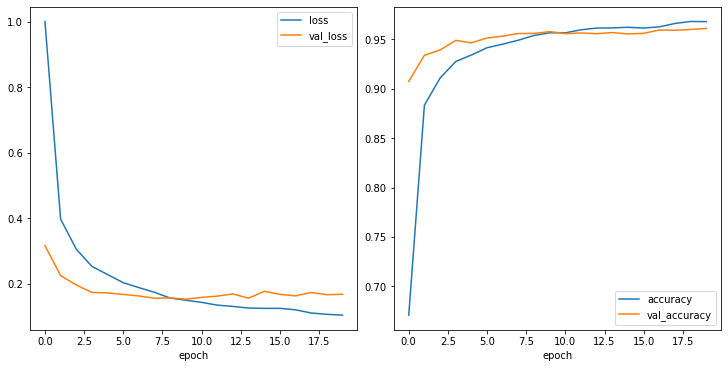

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
history_plot(history)
print(model.summary())

In [8]:
val_acc_list = []
for i in range(num_classes):
	mask = y_test == i
	val_loss, val_acc = model.evaluate(x_test[mask], y_test_cat[mask])
	val_acc_list.append(val_acc)
display.clear_output()
for i in range(num_classes):
	ch = chr(i + 48)
	print(f'{ch}: ', round(val_acc_list[i], 4))

0:  0.9888
1:  0.985
2:  0.9506
3:  0.9545
4:  0.9623
5:  0.926
6:  0.9676
7:  0.964
8:  0.963
9:  0.9514


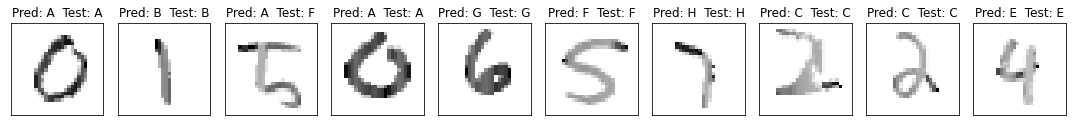

In [9]:

predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)

rs = np.random.randint(0, len(predictions), 10)

# Вывод 10 результатов
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axs.flat):
    idx = rs[i]
    ax.imshow(x_test[idx], cmap=plt.cm.binary)
    ax.set_title('Pred: ' + chr(predictions[idx] + 65) + '  Test: ' + chr(y_test[idx] + 65))
plt.tight_layout()
plt.show()

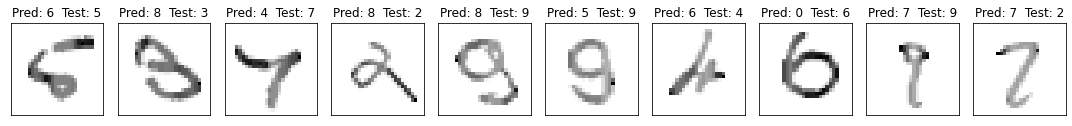

In [10]:
# Выделение неверных вариантов
mask = predictions == y_test

x_false = x_test[~mask]
pred_false = predictions[~mask]
y_false = y_test[~mask]

# Вывод 10 неверных результатов
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axs.flat):
    ax.imshow(x_false[i], cmap=plt.cm.binary)
    ax.set_title('Pred: ' + chr(pred_false[i] + 48) + '  Test: ' + chr(y_false[i] + 48))
plt.tight_layout()
plt.show()

# EMNIST

In [11]:
num_classes = 26
flatten = True
reshape = False

x_train, y_train, x_test, y_test = loadBinData(pathToData, img_rows, img_cols)

y_train -= 1
y_test -= 1

if flatten or reshape:
	x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols).transpose(0,2,1)
	x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols).transpose(0,2,1)
else:
	x_train = x_train.reshape(-1, 784)
	x_test = x_test.reshape(-1, 784)

print(x_train.shape)
print(x_test.shape)

y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

Загрузка данных из двоичных файлов...
(124800, 28, 28)
(20800, 28, 28)


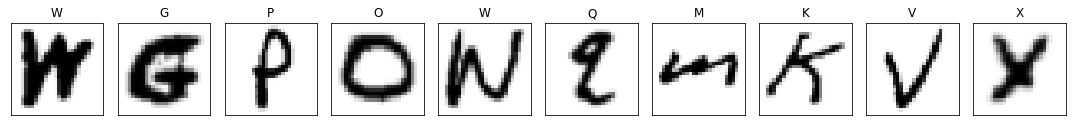

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axs.flat):
	sample = x_train[i].reshape(img_rows, img_cols).transpose(1, 0) if not (flatten or reshape) else x_train[i]
	ax.imshow(sample, cmap=plt.cm.binary)
	ax.set_title(chr(y_train[i] + 65))
plt.tight_layout()
plt.show()

In [13]:
model = tf.keras.Sequential()
if reshape: model.add(tf.keras.layers.Reshape((784,)))
if flatten: model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
#model.add(tf.keras.layers.Dense(32, activation='relu'))

model.add(tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax))

model.compile(	optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
				loss='mse', 
				metrics=['accuracy']
				)

start = time.time()
history = model.fit(x_train, y_train_cat,validation_split=0.2, epochs=30, batch_size=4096)
display.clear_output()
print('Время вычислений:', time.time() - start)
tf.keras.backend.clear_session()

Время вычислений: 9.13508653640747


In [14]:
val_loss, val_acc = model.evaluate(x_test, y_test_cat)
print('Val(test set) accuracy: ', val_acc)
print('Accuracy: ', history.history['accuracy'][-1])
print('Val accuracy: ', history.history['val_accuracy'][-1])

650/650 [==============================] - 2s 2ms/step - loss: 0.0062 - accuracy: 0.8950
Val(test set) accuracy:  0.8950480818748474
Accuracy:  0.9123397469520569
Val accuracy:  0.8995993733406067


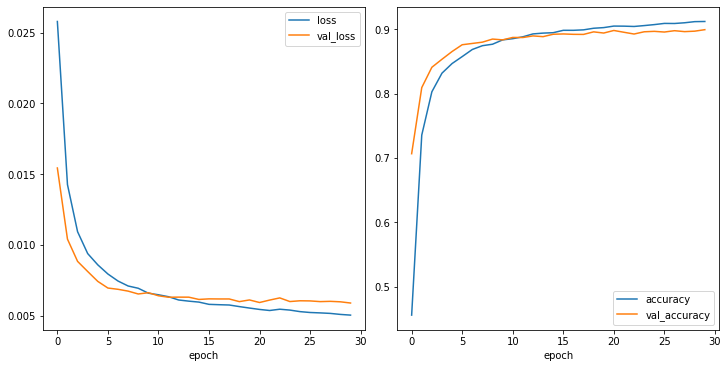

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 26)                3354      
Total params: 120,346
Trainable params: 120,346
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
history_plot(history)
print(model.summary())

In [16]:
val_acc_list = []
for i in range(num_classes):
	mask = y_test == i
	val_loss, val_acc = model.evaluate(x_test[mask], y_test_cat[mask])
	val_acc_list.append(val_acc)
display.clear_output()
for i in range(num_classes):
	ch = chr(i + 65)
	print(f'{ch}: ', round(val_acc_list[i], 4))

A:  0.8325
B:  0.9262
C:  0.9413
D:  0.8888
E:  0.9413
F:  0.92
G:  0.7887
H:  0.8888
I:  0.6712
J:  0.8963
K:  0.8963
L:  0.8087
M:  0.965
N:  0.9237
O:  0.96
P:  0.955
Q:  0.7237
R:  0.905
S:  0.9613
T:  0.9375
U:  0.9388
V:  0.8838
W:  0.9563
X:  0.9262
Y:  0.8775
Z:  0.9575


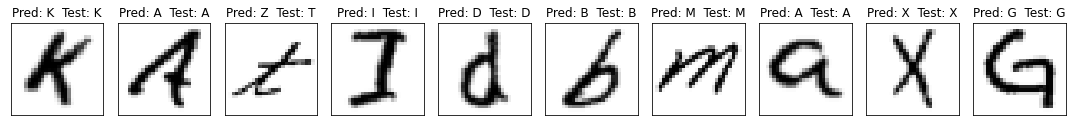

In [17]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)

rs = np.random.randint(0, len(predictions), 10)

# Вывод 10 результатов
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axs.flat):
    idx = rs[i]
    sample = x_test[idx].reshape(img_rows, img_cols).transpose(1, 0) if not (flatten or reshape) else x_test[idx]
    ax.imshow(sample, cmap=plt.cm.binary)
    ax.set_title('Pred: ' + chr(predictions[idx] + 65) + '  Test: ' + chr(y_test[idx] + 65))
plt.tight_layout()
plt.show()

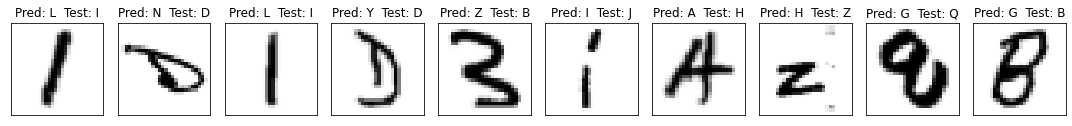

In [18]:
# Выделение неверных вариантов
mask = predictions == y_test

x_false = x_test[~mask]
pred_false = predictions[~mask]
y_false = y_test[~mask]

rs = np.random.randint(0, len(pred_false), 10)

# Вывод 10 неверных результатов
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axs.flat):
    idx = rs[i]
    sample = x_false[idx].reshape(img_rows, img_cols).transpose(1, 0) if not (flatten or reshape) else x_false[idx]
    ax.imshow(sample, cmap=plt.cm.binary)
    ax.set_title('Pred: ' + chr(pred_false[idx] + 65) + '  Test: ' + chr(y_false[idx] + 65))
plt.tight_layout()
plt.show()

# Объединенное множество

In [19]:
flatten = True
reshape = False
x_train_emnist, y_train_emnist, x_test_emnist, y_test_emnist = loadBinData(pathToData, img_rows, img_cols)
y_train_emnist += 9
y_test_emnist += 9

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.concatenate((x_train, x_train_emnist), axis=0)
y_train = np.concatenate((y_train, y_train_emnist), axis=0)
x_test = np.concatenate((x_test, x_test_emnist), axis=0)
y_test = np.concatenate((y_test, y_test_emnist), axis=0)
num_classes = 26 + 10
#print(x_train.shape)
#print(x_test.shape)

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
print(x_train.shape)
print(x_test.shape)
input_shape = (img_rows, img_cols, 1)

y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

Загрузка данных из двоичных файлов...
(184800, 28, 28, 1)
(30800, 28, 28, 1)


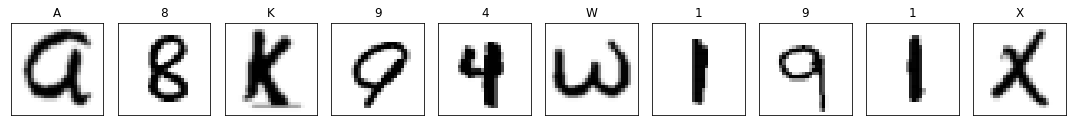

In [20]:
rs = np.random.randint(0, len(x_train), size=10)
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axs.flat):
	idx = rs[i]
	sample = x_train[idx] if y_train[idx] < 10 else x_train[idx].transpose(1, 0, 2) 
	tch = chr(y_train[idx] + 48) if y_train[idx] < 10 else chr(y_train[idx] + 55)
	ax.imshow(sample, cmap=plt.cm.binary)  
	ax.set_title(tch)
plt.tight_layout()
plt.show()

In [21]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(8, kernel_size = (5, 5), strides = (1, 1), padding = 'same', activation = 'tanh', input_shape = input_shape))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

model.add(tf.keras.layers.Conv2D(16, kernel_size = (5, 5), strides = (1, 1), activation = 'tanh'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(400, activation = 'tanh'))
model.add(tf.keras.layers.Dropout(0.6))
model.add(tf.keras.layers.Dense(64, activation = 'linear'))

model.add(tf.keras.layers.Dense(num_classes, activation = 'softmax'))

model.compile(	optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
				loss='categorical_crossentropy', 
				metrics=['accuracy'],
				)

start = time.time()
history = model.fit(x_train, y_train_cat,validation_split=0.2, epochs=25, batch_size=2048)
display.clear_output()
print('Время вычислений:', time.time() - start)
tf.keras.backend.clear_session()

Время вычислений: 35.929096937179565


In [22]:
val_loss, val_acc = model.evaluate(x_test, y_test_cat)
print('Val(test set) accuracy: ', val_acc)
print('Accuracy: ', history.history['accuracy'][-1])
print('Val accuracy: ', history.history['val_accuracy'][-1])

963/963 [==============================] - 3s 3ms/step - loss: 0.1791 - accuracy: 0.9446
Val(test set) accuracy:  0.9446428418159485
Accuracy:  0.9414569735527039
Val accuracy:  0.9246212244033813


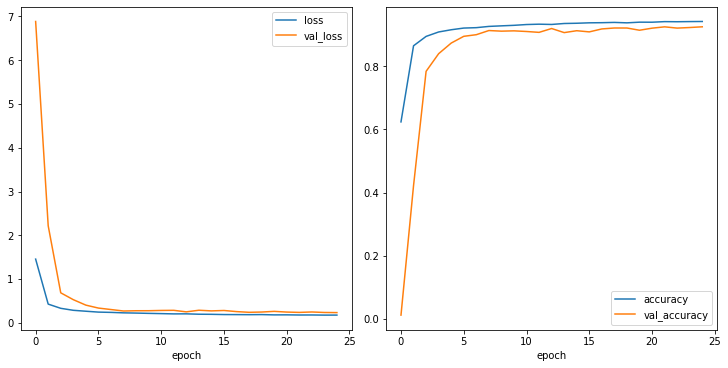

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 8)         208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        3216      
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 10, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 400)               1

In [23]:
history_plot(history)
print(model.summary())

In [24]:
val_acc_list = []
for i in range(num_classes):
	mask = y_test == i
	val_loss, val_acc = model.evaluate(x_test[mask], y_test_cat[mask])
	ch = chr(i + 48) if i < 10 else chr(i + 55)
	val_acc_list.append(val_acc)
display.clear_output()
for i in range(num_classes):
	ch = chr(i + 48) if i < 10 else chr(i + 55)
	print(f'{ch}: ', round(val_acc_list[i], 4))

0:  0.9939
1:  0.9956
2:  0.9922
3:  0.9851
4:  0.9837
5:  0.9865
6:  0.9823
7:  0.9864
8:  0.9754
9:  0.9713
A:  0.91
B:  0.935
C:  0.9613
D:  0.9062
E:  0.9538
F:  0.9187
G:  0.7675
H:  0.9425
I:  0.7487
J:  0.92
K:  0.9613
L:  0.7625
M:  0.9762
N:  0.9513
O:  0.9787
P:  0.9862
Q:  0.8838
R:  0.9337
S:  0.9488
T:  0.9712
U:  0.9438
V:  0.94
W:  0.9762
X:  0.9325
Y:  0.9563
Z:  0.985


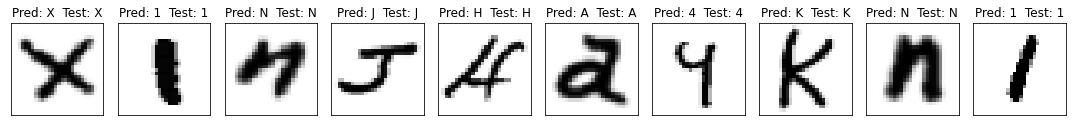

In [25]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)

# Выделение неверных вариантов
show_false = False

if show_false:
    mask = predictions == y_test
    x_false = x_test[~mask]
    pred_false = predictions[~mask]
    y_false = y_test[~mask]
    rs = np.random.randint(0, len(pred_false), 10)
else:
    rs = np.random.randint(0, len(predictions), 10)

# Вывод первых 25 неверных результатов
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axs.flat):
    idx = rs[i]
    if show_false:
        sample = x_false[idx] if y_false[idx] < 10 else x_false[idx].transpose(1, 0, 2)   
        pch = chr(pred_false[idx] + 48) if pred_false[idx] < 10 else chr(pred_false[idx] + 55)
        tch = chr(y_false[idx] + 48) if y_false[idx] < 10 else chr(y_false[idx] + 55)
    else:
        sample = x_test[idx] if y_test[idx] < 10 else x_test[idx].transpose(1, 0, 2)   
        pch = chr(predictions[idx] + 48) if predictions[idx] < 10 else chr(predictions[idx] + 55)
        tch = chr(y_test[idx] + 48) if y_test[idx] < 10 else chr(y_test[idx] + 55)
    ax.imshow(sample, cmap=plt.cm.binary)
    ax.set_title('Pred: ' + pch + '  Test: ' + tch)
plt.tight_layout()
plt.show()